In [1]:
!pip install fastai==1.0.47

    100% |████████████████████████████████| 215kB 24.9MB/s 
  Found existing installation: fastai 1.0.51
    Uninstalling fastai-1.0.51:
      Successfully uninstalled fastai-1.0.51
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch

In [3]:
data_folder = Path("../input")

In [4]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/sample_submission.csv")


In [5]:
test_img = ImageList.from_df(test_df, path=data_folder/'test', folder='test')
trfm = get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.3, p_affine=0.75, p_lighting=0.75)
train_img = (ImageList.from_df(train_df, path=data_folder/'train', folder='train')
        .split_by_rand_pct(0.01)
        .label_from_df()
        .add_test(test_img)
        .transform(trfm, size=224)
        .databunch(path='.', bs=32, device= torch.device('cuda:0'))
        .normalize(imagenet_stats)
       )


In [6]:
from torchvision.models import ResNet,resnet18,resnet34,resnet50,resnet101,resnet152
from torchvision.models import SqueezeNet,squeezenet1_0,squeezenet1_1
from torchvision.models import densenet121,densenet169,densenet201,densenet161
from torchvision.models import vgg16_bn,vgg19_bn,alexnet

In [7]:
learn = cnn_learner(train_img,resnet152, metrics=[error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /tmp/.torch/models/resnet152-b121ed2d.pth
241530880it [00:10, 23866948.92it/s]


In [8]:
lrf = learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


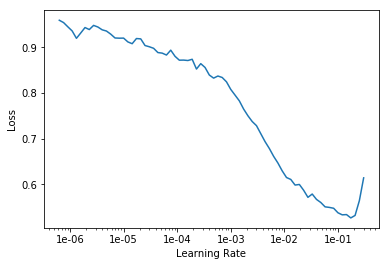

In [9]:
learn.recorder.plot()

In [10]:
lr = 1e-2
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.069290,0.018092,0.011429,0.988571,03:24
1,0.037112,0.002513,0.000000,1.000000,03:04
2,0.042262,0.003989,0.000000,1.000000,03:07
3,0.007132,0.004907,0.005714,0.994286,03:04
4,0.005192,0.002697,0.000000,1.000000,02:56


In [11]:
preds,_ = learn.get_preds(ds_type=DatasetType.Test)
test_df.has_cactus = preds.numpy()[:, 0]
test_df.to_csv('sub.csv', index=False)